#### 初探量化世界

##### 量化交易

* 行情模块
* 策略模块
* 回测模块
* 执行模块

In [2]:
import json
import requests


gemini_ticker = 'https://api.gemini.com/v1/pubticker/{}'
symbol = 'btcusd'
btc_data = requests.get(gemini_ticker.format(symbol)).json()
print(json.dumps(btc_data, indent=4))

{
    "bid": "9885.23",
    "ask": "9888.18",
    "volume": {
        "BTC": "3921.7132092614",
        "USD": "40032757.2206319515670000000000000000047129192",
        "timestamp": 1565840400000
    },
    "last": "9888.18"
}


##### 算法交易

    CloseTime  OpenPrice      ...           Volume             NA
0  1564038000   10081.53      ...        15.306403  154094.516257
1  1564041600   10099.07      ...        10.834025  109277.214994
2  1564045200   10060.65      ...         7.524899   76012.030932
3  1564048800   10096.82      ...        18.087139  182768.844170
4  1564052400   10080.00      ...        14.570308  146898.362174

[5 rows x 7 columns]


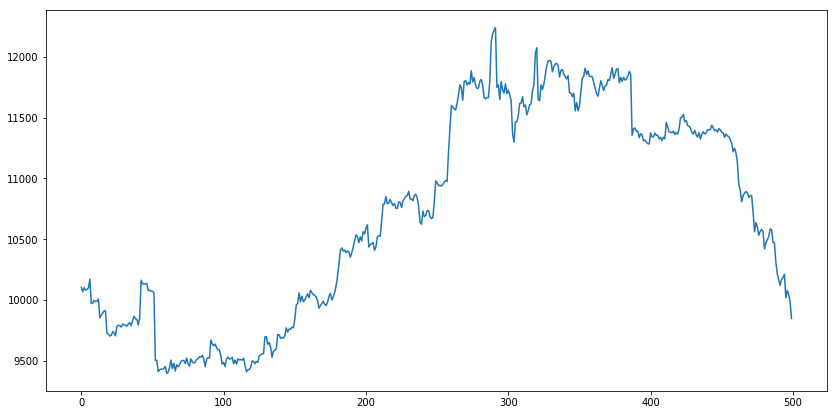

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import requests


periods = '3600'

resp = requests.get('https://api.cryptowat.ch/markets/gemini/btcusd/ohlc', 
                    params={'periods': periods})
data = resp.json()

df = pd.DataFrame(
    data['result'][periods], 
    columns=[
        'CloseTime', 
        'OpenPrice',
        'HighPrice',
        'LowPrice',
        'ClosePrice',
        'Volume',
        'NA'
    ]
)

print(df.head())

df['ClosePrice'].plot(figsize=(14, 7))


#### RESTful & Socket

##### 搭建交易执行层核心

In [13]:
import requests
import json
import base64
import hmac
import hashlib
import datetime
import time

base_url = "https://api.sandbox.gemini.com"
endpoint = "/v1/order/new"
url = base_url + endpoint

gemini_api_key = "account-zmidXEwP72yLSSybXVvn"
gemini_api_secret = "375b97HfE7E4tL8YaP3SJ239Pky9".encode()

t = datetime.datetime.now()
payload_nonce = str(int(time.mktime(t.timetuple())*1000))

payload = {
   "request": "/v1/order/new",
   "nonce": payload_nonce,
   "symbol": "btcusd",
   "amount": "5",
   "price": "3600.00",
   "side": "buy",
   "type": "exchange limit",
   "options": ["maker-or-cancel"]
}

encoded_payload = json.dumps(payload).encode()
b64 = base64.b64encode(encoded_payload)
signature = hmac.new(gemini_api_secret, b64, hashlib.sha384).hexdigest()

request_headers = {
    'Content-Type': "text/plain",
    'Content-Length': "0",
    'X-GEMINI-APIKEY': gemini_api_key,
    'X-GEMINI-PAYLOAD': b64,
    'X-GEMINI-SIGNATURE': signature,
    'Cache-Control': "no-cache"
}

response = requests.post(
    url,
    data=None,
    headers=request_headers
)

new_order = response.json()
print(new_order)

{'result': 'error', 'reason': 'InsufficientFunds', 'message': "Failed to place buy order on symbol 'BTCUSD' for price $3,600.00 and quantity 5 BTC due to insufficient funds"}


#### 行情数据对接和抓取

##### WebSocket 介绍

In [1]:
import ssl
import websocket
import json

# 全局计数器
count = 5

def on_message(ws, message):
    global count
    print(message)
    count -= 1
    if count == 0:
        ws.close()

if __name__ == "__main__":
    ws = websocket.WebSocketApp(
        "wss://api.gemini.com/v1/marketdata/btcusd?top_of_book=true&offers=true",
        on_message=on_message)
    ws.run_forever(sslopt={"cert_reqs": ssl.CERT_NONE})

{"type":"update","eventId":7787344127,"socket_sequence":0,"events":[{"type":"change","reason":"initial","price":"9567.83","delta":"0.58360673","remaining":"0.58360673","side":"ask"}]}
{"type":"update","eventId":7787346190,"timestamp":1565852563,"timestampms":1565852563100,"socket_sequence":1,"events":[{"type":"change","side":"ask","price":"9567.83","remaining":"0.43509519","reason":"top-of-book"}]}
{"type":"update","eventId":7787347157,"timestamp":1565852567,"timestampms":1565852567148,"socket_sequence":2,"events":[{"type":"change","side":"ask","price":"9575.43","remaining":"2","reason":"top-of-book"}]}
{"type":"update","eventId":7787347161,"timestamp":1565852567,"timestampms":1565852567149,"socket_sequence":3,"events":[{"type":"change","side":"ask","price":"9575.42","remaining":"0.15711231","reason":"top-of-book"}]}
{"type":"update","eventId":7787347191,"timestamp":1565852567,"timestampms":1565852567248,"socket_sequence":4,"events":[{"type":"change","side":"ask","price":"9575.40","rem

##### 行情抓取模块

In [ ]:
import copy
import json
import ssl
import time
import websocket


class OrderBook(object):

    BIDS = 'bid'
    ASKS = 'ask'

    def __init__(self, limit=20):

        self.limit = limit
        
        self.bids = {}
        self.asks = {}

        self.bids_sorted = []
        self.asks_sorted = []

    def insert(self, price, amount, direction):
        if direction == self.BIDS:
            if amount == 0:
                if price in self.bids:
                    del self.bids[price]
            else:
                self.bids[price] = amount
        elif direction == self.ASKS:
            if amount == 0:
                if price in self.asks:
                    del self.asks[price]
            else:
                self.asks[price] = amount
        else:
            print('WARNING: unknown direction {}'.format(direction))

    def sort_and_truncate(self):
        self.bids_sorted = sorted([(price, amount) for price, amount in self.bids.items()], reverse=True)
        self.asks_sorted = sorted([(price, amount) for price, amount in self.asks.items()])

        self.bids_sorted = self.bids_sorted[:self.limit]
        self.asks_sorted = self.asks_sorted[:self.limit]

        self.bids = dict(self.bids_sorted)
        self.asks = dict(self.asks_sorted)

    def get_copy_of_bids_and_asks(self):
        return copy.deepcopy(self.bids_sorted), copy.deepcopy(self.asks_sorted)


class Crawler:
    def __init__(self, symbol, output_file):
        self.orderbook = OrderBook(limit=10)
        self.output_file = output_file

        self.ws = websocket.WebSocketApp('wss://api.gemini.com/v1/marketdata/{}'.format(symbol),
                                          on_message = lambda ws, message: self.on_message(message))
        self.ws.run_forever(sslopt={'cert_reqs': ssl.CERT_NONE})

    def on_message(self, message):
        # 对收到的信息进行处理后送给 orderbook
        data = json.loads(message)
        for event in data['events']:
            price, amount, direction = float(event['price']), float(event['remaining']), event['side']
            self.orderbook.insert(price, amount, direction)

        # 整理排序 orderbook
        self.orderbook.sort_and_truncate()

        # 输出到文件
        with open(self.output_file, 'a+') as f:
            bids, asks = self.orderbook.get_copy_of_bids_and_asks()
            output = {
                'bids': bids,
                'asks': asks,
                'ts': int(time.time() * 1000)
            }
            f.write(json.dumps(output) + '\n')


if __name__ == '__main__':
    crawler = Crawler(symbol='BTCUSD', output_file='BTCUSD.txt')

#### 回测框架

##### 向量型回测框架

* 读取OHLC数据
* 对OHLC进行指标运算
* 策略根据指标向量决定买卖
* 发给模拟的“交易所”进行交易
* 统计结果

In [ ]:
class Backtest:
    """
    Backtest 回测类：用于读取历史行情数据、执行策略、模拟交易并估计收益

    初始化的时候调用 Backtest.run 来时回测

    instance, or `backtesting.backtesting.Backtest.optimize` to
    optimize it.
    """

    def __init__(self,
                 data: pd.DataFrame,
                 strategy_type: type(Strategy),
                 broker_type: type(ExchangeAPI),
                 cash: float = 10000,
                 commission: float = .0):
        """
        构造回测对象。需要的参数包括：历史数据，策略对象，初始资金数量，手续费率等。
        初始化过程包括检测输入类型，填充数据空值等。

        参数：
        :param data:            pd.DataFrame        pandas Dataframe 格式的历史 OHLCV 数据
        :param broker_type:     type(ExchangeAPI)   交易所 API 类型，负责执行买卖操作以及账户状态的维护
        :param strategy_type:   type(Strategy)      策略类型
        :param cash:            float               初始资金数量
        :param commission:       float               每次交易手续费率。如 2% 的手续费此处为 0.02
        """

        assert_msg(issubclass(strategy_type, Strategy), 'strategy_type 不是一个 Strategy 类型')
        assert_msg(issubclass(broker_type, ExchangeAPI), 'strategy_type 不是一个 Strategy 类型')
        assert_msg(isinstance(commission, Number), 'commission 不是浮点数值类型')

        data = data.copy(False)

        # 如果没有 Volumn 列，填充 NaN
        if 'Volume' not in data:
            data['Volume'] = np.nan

        # 验证 OHLC 数据格式
        assert_msg(len(data.columns & {'Open', 'High', 'Low', 'Close', 'Volume'}) == 5,
                   (" 输入的`data`格式不正确，至少需要包含这些列："
                    "'Open', 'High', 'Low', 'Close'"))

        # 检查缺失值
        assert_msg(not data[['Open', 'High', 'Low', 'Close']].max().isnull().any(),
            ('部分 OHLC 包含缺失值，请去掉那些行或者通过差值填充. '))

        # 如果行情数据没有按照时间排序，重新排序一下
        if not data.index.is_monotonic_increasing:
            data = data.sort_index()

        # 利用数据，初始化交易所对象和策略对象。
        self._data = data  # type: pd.DataFrame
        self._broker = broker_type(data, cash, commission)
        self._strategy = strategy_type(self._broker, self._data)
        self._results = None

    def run(self):
        """
        运行回测，迭代历史数据，执行模拟交易并返回回测结果。
        Run the backtest. Returns `pd.Series` with results and statistics.

        Keyword arguments are interpreted as strategy parameters.
        """
        strategy = self._strategy
        broker = self._broker

        # 策略初始化
        strategy.init()

        # 设定回测开始和结束位置
        start = 100
        end = len(self._data)

        # 回测主循环，更新市场状态，然后执行策略
        for i in range(start, end):
            # 注意要先把市场状态移动到第 i 时刻，然后再执行策略。
            broker.next(i)
            strategy.next(i)

        # 完成策略执行之后，计算结果并返回
        self._results = self._compute_result(broker)
        return self._results

    def _compute_result(self, broker):
        s = pd.Series()
        s['初始市值'] = broker.initial_cash
        s['结束市值'] = broker.market_value
        s['收益'] = broker.market_value - broker.initial_cash
        return s

##### 事件驱动型回测框架

    * Zipline
    * PyAlgoTrade

#### 交易策略

##### 引入工具函数

In [ ]:
def SMA(values, n):
    """
    返回简单滑动平均
    """
    return pd.Series(values).rolling(n).mean()

def crossover(series1, series2) -> bool:
    """
    检查两个序列是否在结尾交叉
    :param series1:  序列 1
    :param series2:  序列 2
    :return:         如果交叉返回 True，反之 False
    """
    return series1[-2] < series2[-2] and series1[-1] > series2[-1]

##### 策略核心思想

In [ ]:
def next(self, tick):
    # 如果此时快线刚好越过慢线，买入全部
    if crossover(self.sma1[:tick], self.sma2[:tick]):
        self.buy()

    # 如果是慢线刚好越过快线，卖出全部
    elif crossover(self.sma2[:tick], self.sma1[:tick]):
        self.sell()

    # 否则，这个时刻不执行任何操作。
    else:
        pass

##### 定义策略子类

In [ ]:
import abc
import numpy as np
from typing import Callable

class Strategy(metaclass=abc.ABCMeta):
    """
    抽象策略类，用于定义交易策略。

    如果要定义自己的策略类，需要继承这个基类，并实现两个抽象方法：
    Strategy.init
    Strategy.next
    """
    def __init__(self, broker, data):
        """
        构造策略对象。

        @params broker:  ExchangeAPI    交易 API 接口，用于模拟交易
        @params data:    list           行情数据数据
        """
        self._indicators = []
        self._broker = broker  # type: _Broker
        self._data = data  # type: _Data
        self._tick = 0

    def I(self, func: Callable, *args) -> np.ndarray:
        """
        计算买卖指标向量。买卖指标向量是一个数组，长度和历史数据对应；
        用于判定这个时间点上需要进行 " 买 " 还是 " 卖 "。

        例如计算滑动平均：
        def init():
            self.sma = self.I(utils.SMA, self.data.Close, N)
        """
        value = func(*args)
        value = np.asarray(value)
        assert_msg(value.shape[-1] == len(self._data.Close), '指示器长度必须和 data 长度相同')

        self._indicators.append(value)
        return value

    @property
    def tick(self):
        return self._tick

    @abc.abstractmethod
    def init(self):
        """
        初始化策略。在策略回测 / 执行过程中调用一次，用于初始化策略内部状态。
        这里也可以预计算策略的辅助参数。比如根据历史行情数据：
        计算买卖的指示器向量；
        训练模型 / 初始化模型参数
        """
        pass

    @abc.abstractmethod
    def next(self, tick):
        """
        步进函数，执行第 tick 步的策略。tick 代表当前的 " 时间 "。比如 data[tick] 用于访问当前的市场价格。
        """
        pass

    def buy(self):
        self._broker.buy()

    def sell(self):
        self._broker.sell()

    @property
    def data(self):
        return self._data

##### 实现交叉策略

In [ ]:
from utils import assert_msg, crossover, SMA

class SmaCross(Strategy):
    # 小窗口 SMA 的窗口大小，用于计算 SMA 快线
    fast = 10

    # 大窗口 SMA 的窗口大小，用于计算 SMA 慢线
    slow = 20

    def init(self):
        # 计算历史上每个时刻的快线和慢线
        self.sma1 = self.I(SMA, self.data.Close, self.fast)
        self.sma2 = self.I(SMA, self.data.Close, self.slow)

    def next(self, tick):
        # 如果此时快线刚好越过慢线，买入全部
        if crossover(self.sma1[:tick], self.sma2[:tick]):
            self.buy()

        # 如果是慢线刚好越过快线，卖出全部
        elif crossover(self.sma2[:tick], self.sma1[:tick]):
            self.sell()

        # 否则，这个时刻不执行任何操作。
        else:
            pass

#### 模拟交易

In [ ]:
from utils import read_file, assert_msg, crossover, SMA

class ExchangeAPI:
    def __init__(self, data, cash, commission):
        assert_msg(0 < cash, " 初始现金数量大于 0，输入的现金数量：{}".format(cash))
        assert_msg(0 <= commission <= 0.05, " 合理的手续费率一般不会超过 5%，输入的费率：{}".format(commission))
        self._inital_cash = cash
        self._data = data
        self._commission = commission
        self._position = 0
        self._cash = cash
        self._i = 0

    @property
    def cash(self):
        """
        :return: 返回当前账户现金数量
        """
        return self._cash

    @property
    def position(self):
        """
        :return: 返回当前账户仓位
        """
        return self._position

    @property
    def initial_cash(self):
        """
        :return: 返回初始现金数量
        """
        return self._inital_cash

    @property
    def market_value(self):
        """
        :return: 返回当前市值
        """
        return self._cash + self._position * self.current_price

    @property
    def current_price(self):
        """
        :return: 返回当前市场价格
        """
        return self._data.Close[self._i]

    def buy(self):
        """
        用当前账户剩余资金，按照市场价格全部买入
        """
        self._position = float(self._cash / (self.current_price * (1 + self._commission)))
        self._cash = 0.0

    def sell(self):
        """
        卖出当前账户剩余持仓
        """
        self._cash += float(self._position * self.current_price * (1 - self._commission))
        self._position = 0.0

    def next(self, tick):
        self._i = tick